In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn import metrics

#GridSearchCV
from sklearn.model_selection import GridSearchCV

#SVM
from sklearn import svm

#XGB
import xgboost as xgb

#RandomForest
from sklearn.ensemble import RandomForestClassifier

#VotingClassifier
from sklearn.ensemble import VotingClassifier

#ConfusionMatrix
from sklearn.metrics import confusion_matrix

In [3]:
# manual parameters
TEST_RATIO = 0.2
RANDOM_SEED = 42

In [4]:
train = pd.read_csv("/home/vijay/Desktop/ML_datasets/train_LZdllcl.csv")
test = pd.read_csv("/home/vijay/Desktop/ML_datasets/test_2umaH9m.csv")

In [5]:
#1.Feature engineering
#checking for missing values in the dataset 
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

,Total,Percent
previous_year_rating,4124,7.524449
education,2409,4.395344


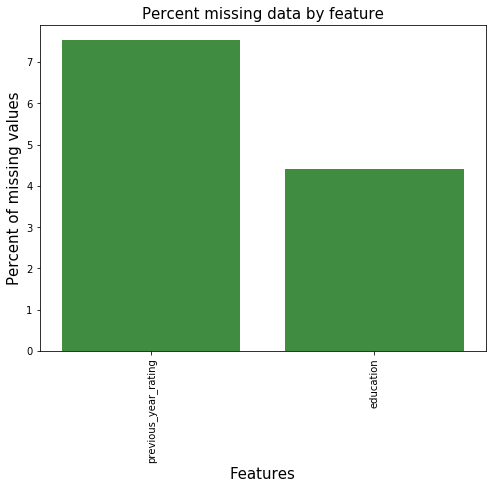

In [6]:
missingdata(train)

In [7]:
train = train.dropna()

In [8]:
train = train.drop(['region', 'gender', 'age', 'recruitment_channel','employee_id'], axis=1)

In [9]:
#once again checking for null values 
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(9)

,Total,%
is_promoted,0,0.0
avg_training_score,0,0.0
awards_won?,0,0.0
KPIs_met >80%,0,0.0
length_of_service,0,0.0
previous_year_rating,0,0.0
no_of_trainings,0,0.0
education,0,0.0
department,0,0.0


In [10]:
#resetting index values 
train = train.reset_index(drop = True)

,Total,Percent
previous_year_rating,1812,7.713921
education,1034,4.401873


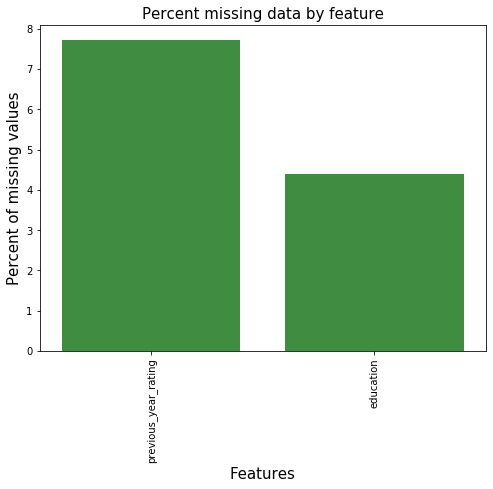

In [11]:
missingdata(test)

In [12]:
test = test.dropna()

In [13]:
test = test.drop(['region', 'gender', 'age', 'recruitment_channel'], axis=1)

In [14]:
test = test.reset_index(drop = True)

In [15]:
labels = train.is_promoted.values.tolist()
labels1 = train.department.values.tolist()
df = pd.DataFrame(list(zip(labels1, labels)),
               columns =['DEPT', 'PROM'])
df

,DEPT,PROM
0,Sales & Marketing,0
1,Operations,0
2,Sales & Marketing,0
3,Sales & Marketing,0
4,Technology,0
...,...,...
48655,Sales & Marketing,0
48656,Technology,0
48657,Operations,0
48658,Analytics,0


In [16]:
dept_emp_num =  df.groupby('DEPT')['DEPT'].count().sort_values(ascending=False)
print(dept_emp_num)

DEPT
Sales & Marketing    14239
Operations           10547
Procurement           6641
Technology            6502
Analytics             4610
Finance               2219
HR                    2142
R&D                    893
Legal                  867
Name: DEPT, dtype: int64


In [17]:
df_filtered = df[df['PROM'] == 1]
dept_emp_num1 =  df_filtered.groupby('DEPT')['DEPT'].count().sort_values(ascending=False)
print(dept_emp_num1)

DEPT
Sales & Marketing    1060
Operations            979
Technology            694
Procurement           651
Analytics             445
Finance               182
HR                    121
R&D                    58
Legal                  42
Name: DEPT, dtype: int64


In [18]:
#2.Data Cleaning
edu = {"Master's & above": 1, "Bachelor's": 2, "Below Secondary": 3}
data = [train,test]

for dataset in data:
    dataset['education'] = dataset['education'].map(edu)

In [19]:
dept = {"Sales & Marketing": 1, "Operations": 2, "Technology": 3, "Analytics": 4, "R&D": 5, "Procurement": 6, "Finance": 7, "HR": 8, "Legal": 9}
data = [train,test]

for dataset in data:
    dataset['department'] = dataset['department'].map(dept)

In [20]:
train.head()

,department,education,no_of_trainings,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,1,1,1,5.0,8,1,0,49,0
1,2,2,1,5.0,4,0,0,60,0
2,1,2,1,3.0,7,0,0,50,0
3,1,2,2,1.0,10,0,0,50,0
4,3,2,1,3.0,2,0,0,73,0


In [21]:
test.head()

,employee_id,department,education,no_of_trainings,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,74430,8,2,1,3.0,5,0,0,51
1,72255,1,2,1,1.0,4,0,0,47
2,38562,6,2,3,2.0,9,0,0,65
3,64486,7,2,1,4.0,7,0,0,61
4,46232,6,2,1,3.0,2,0,0,68


In [22]:
train = train.head(7000)

In [23]:
test = test.head(4500)

In [24]:
emp_id = test.employee_id

In [25]:
#Data Splitting-------------
features = train.drop('is_promoted', axis=1).values
labels = train.is_promoted.values

# splitting our 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=TEST_RATIO,
                                                    random_state=RANDOM_SEED)

In [26]:
def training_accuracy_report(GridSearchCv_classifier):
    print(
f"""Best parameters: 
    {GridSearchCv_classifier.best_params_}
    
Best estimator:
    {GridSearchCv_classifier.best_estimator_}
    
Mean cross-validated score of the best_estimator on the training set:
    {GridSearchCv_classifier.best_score_*100:,.2f}%    
""")

In [27]:
#Classification
#SVM----------------------------------
# parameter grid for our search
parameters = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4], # only applies to kernel == 'poly'
    'kernel': ('linear', 'rbf', 'poly')
}

# initiating our support vector machine
svm = svm.SVC(gamma='scale',
              probability=True,
              random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=svm,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_svm = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_svm)

Best parameters: 
    {'C': 10, 'degree': 4, 'kernel': 'poly'}
    
Best estimator:
    SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
    
Mean cross-validated score of the best_estimator on the training set:
    91.25%    



In [28]:
# for accuracy calculation
from sklearn import metrics

# make predictions
y_pred_svm = best_svm.predict(X_test)
accuracy_svm = metrics.accuracy_score(y_test, y_pred_svm)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_svm*100:,.2f}%')

Accuracy on the test set: 92.50%


In [29]:
#XGB---------------------------------------
# parameter grid for our search
parameters = {
    'min_child_weight': [5, 6, 7],
    'gamma': [0, 0.2],
    'colsample_bytree': [0, 0.2, 0.4],
    'max_depth': [3, 4, 5]
}

# initiating our gradient boosted tree
xgb = xgb.XGBClassifier(objective='reg:squarederror', random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=xgb,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_xgb = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_xgb)

Best parameters: 
    {'colsample_bytree': 0.4, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 7}
    
Best estimator:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
    
Mean cross-validated score of the best_estimator on the training set:
    93.54%    



In [30]:
# make predictions
y_pred_xgb = best_xgb.predict(X_test)
accuracy_xgb = metrics.accuracy_score(y_test, y_pred_xgb)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_xgb*100:,.2f}%')

Accuracy on the test set: 94.14%


In [31]:
#RandomForest---------------------------
# parameter grid for our search
parameters = {
    'n_estimators': [75, 100, 125, ],
    'max_depth': [10, 50, 100, None],
    'max_features': [0.5, 1],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [2, 3]
}

rfc = RandomForestClassifier(criterion='gini',
                             bootstrap=False,
                             random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=rfc,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_rfc = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_rfc)


Best parameters: 
    {'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 75}
    
Best estimator:
    RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
    
Mean cross-validated score of the best_estimator on the training set:
    92.96%    



In [32]:
# make predictions
y_pred_rfc = best_rfc.predict(X_test)
accuracy_rfc = metrics.accuracy_score(y_test, y_pred_rfc)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_rfc*100:,.2f}%')

Accuracy on the test set: 92.79%


In [33]:
# configuring 
#VotingClassifier---------------------------
vc = VotingClassifier(
    
    # all classifiers we just gridsearched
    estimators=[
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('rfc', best_rfc)
    ], 
    
    # soft = probabilities are taken into account
    # hard = only the outcome counts
    voting='soft',
    
    # you can add weights, as well. E.g.
    weights=[1,4,1]
    
)

# fitting
vc = vc.fit(X_train, y_train)

In [34]:
# accuracy on test set
y_pred_vc = vc.predict(X_test)
accuracy_vc = metrics.accuracy_score(y_test, y_pred_vc)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_vc*100:,.2f}%')

Accuracy on the test set: 94.07%


In [35]:
test = test.drop(['employee_id'], axis=1)

In [36]:
#ConfusionMatrix--------------------
results = confusion_matrix(y_test, y_pred_xgb)
print(results)

[[1279    4]
 [  78   39]]


In [37]:
pred = best_xgb.predict(test.values)

In [38]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
Promotion = pd.Series(pred, name="is_promoted")

In [40]:
submission = pd.concat([emp_id, Promotion], axis=1)

In [41]:
submission.to_csv(r'/home/vijay/Desktop/ML_datasets/Output.csv', index=False)

In [42]:
feature_importances = best_xgb.best_estimator_.feature_importances_

In [43]:
feature_importances

array([0.18824868, 0.03414061, 0.02797543, 0.07918282, 0.03094321,
       0.24915205, 0.15024072, 0.24011648], dtype=float32)

In [44]:
feature_names = test.columns.tolist()

In [45]:
feature_imp = feature_importances.tolist() 

In [46]:
df = pd.DataFrame(list(zip(feature_names, feature_imp)),
               columns =['FEATURE_NAMES', 'FEATURE_IMPORTANCE'])

In [47]:
df

,FEATURE_NAMES,FEATURE_IMPORTANCE
0,department,0.188249
1,education,0.034141
2,no_of_trainings,0.027975
3,previous_year_rating,0.079183
4,length_of_service,0.030943
5,KPIs_met >80%,0.249152
6,awards_won?,0.150241
7,avg_training_score,0.240116


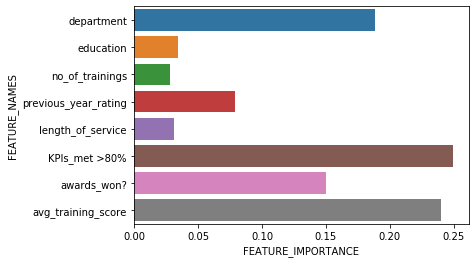

In [48]:
sns.barplot(x='FEATURE_IMPORTANCE', y='FEATURE_NAMES', data=df)

In [49]:
#accuracy of each models 
acc_svm = round(accuracy_svm*100, 2)
acc_xgb = round(accuracy_xgb*100, 2)
acc_rfc = round(accuracy_rfc*100, 2)
acc_vc = round(accuracy_vc*100, 2)

In [50]:
#mean_squared_error
mae_svm = round(metrics.mean_absolute_error(y_test, best_svm.predict(X_test))*100, 2)
mae_xgb = round(metrics.mean_absolute_error(y_test, best_xgb.predict(X_test))*100, 2)
mae_rfc = round(metrics.mean_absolute_error(y_test, best_rfc.predict(X_test))*100, 2)
mae_vc = round(metrics.mean_absolute_error(y_test, vc.predict(X_test))*100, 2)


In [51]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'XGBoost', 'Random Forest Classifier', 'Voting Classifier'],
    'Score': [acc_svm, acc_xgb, acc_rfc, acc_vc],
    'MAE': [mae_svm,mae_xgb,mae_rfc,mae_vc]})
            
result_df = results.sort_values(by='Score', ascending=False)
result_df

,Model,Score,MAE
1,XGBoost,94.14,5.86
3,Voting Classifier,94.07,5.93
2,Random Forest Classifier,92.79,7.21
0,Support Vector Machines,92.50,7.50
